# 03 - Join Optimization: Sort-Merge vs. Broadcast Hash Join

**Objective:** Compare performance of different join strategies in Spark.

This notebook demonstrates:
1. **Sort-Merge Join**: Default join for large tables (requires shuffle)
2. **Broadcast Hash Join**: Optimized join for small dimension tables
3. **Impact of Z-Ordering**: Effect on join performance
4. **Physical Plan Analysis**: Understanding Spark's execution plan

---

## Setup and Imports

In [1]:
# Add src directory to path
import sys
from pathlib import Path

notebook_dir = Path.cwd()
project_root = notebook_dir.parent
src_dir = project_root / "src"
sys.path.insert(0, str(src_dir))

print(f"Project root: {project_root}")
print(f"Src directory: {src_dir}")

Project root: C:\Users\samvo\source\repos\Spark-Performance-Benchmark
Src directory: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\src


In [2]:
import os
import sys
from pathlib import Path

# Add src directory to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
src_dir = project_root / "src"
sys.path.insert(0, str(src_dir))

# Import project modules
from config import (
    get_data_path,
    SPARK_APP_NAME,
    PLOTS_DIR,
    configure_hadoop_home # <--- Import
)
from benchmark_utils import BenchmarkTimer, print_benchmark_summary

# 1. HADOOP_HOME konfigurieren
configure_hadoop_home()

# 2. PATH härten (für Windows DLLs)
if os.environ.get('HADOOP_HOME'):
    bin_path = os.path.join(os.environ['HADOOP_HOME'], 'bin')
    if bin_path not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + bin_path
        print(f"✓ Added to PATH: {bin_path}")

print(f"Project root: {project_root}")

✓ All directories verified/created successfully
✓ HADOOP_HOME already set: C:\hadoop
✓ Added to PATH: C:\hadoop\bin
Project root: C:\Users\samvo\source\repos\Spark-Performance-Benchmark


## Initialize Spark Session

We'll configure Spark with specific settings to control join behavior.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Initialize Spark Session with Delta Support & AQE
spark = (
    SparkSession.builder
    .appName(f"{SPARK_APP_NAME} - Join Optimization")
    .master("local[*]")
    # Delta Dependencies
    .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.0.0")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    # Performance Configs
    .config("spark.sql.adaptive.enabled", "true")  # AQE aktivieren
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.warehouse.dir", "file:///C:/temp")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print(f"✓ Spark {spark.version} session initialized with AQE enabled")

✓ Spark 3.5.0 session initialized with AQE enabled


## Load Data from Parquet Format

We'll use Parquet format for these benchmarks to ensure optimal read performance.

In [4]:
# Load fact_transactions from Parquet
print("Loading fact_transactions table...")
fact_transactions_path = str(get_data_path("parquet", "fact_transactions"))
fact_transactions = spark.read.parquet(fact_transactions_path)
print(f"✓ Loaded {fact_transactions.count():,} sales records")
print("\nSchema:")
fact_transactions.printSchema()

Loading fact_transactions table...
✓ Loaded 6,362,620 sales records

Schema:
root
 |-- transaction_id: long (nullable = true)
 |-- time_step: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- account_orig: string (nullable = true)
 |-- balance_orig_before: double (nullable = true)
 |-- balance_orig_after: double (nullable = true)
 |-- account_dest: string (nullable = true)
 |-- balance_dest_before: double (nullable = true)
 |-- balance_dest_after: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- is_flagged_fraud: integer (nullable = true)



In [5]:
# Load dim_accounts from Parquet
print("Loading dim_accounts table...")
dim_accounts_path = str(get_data_path("parquet", "dim_accounts"))
dim_accounts = spark.read.parquet(dim_accounts_path)
print(f"✓ Loaded {dim_accounts.count():,} customer records")
print("\nSchema:")
dim_accounts.printSchema()

Loading dim_accounts table...
✓ Loaded 9,073,900 customer records

Schema:
root
 |-- account_id: string (nullable = true)
 |-- account_type: string (nullable = true)
 |-- total_transactions: long (nullable = true)
 |-- total_volume: double (nullable = true)
 |-- fraud_count: long (nullable = true)
 |-- fraud_rate: double (nullable = true)



## Understanding Join Strategies

### Sort-Merge Join
- Both tables are sorted by join key
- Requires shuffle (data movement across nodes)
- Good for large-large table joins
- More expensive due to shuffle overhead

### Broadcast Hash Join
- Small table is broadcasted to all nodes
- No shuffle required
- Excellent for large-small table joins (dimension tables)
- Limited by broadcast threshold

## Scenario A: Sort-Merge Join (Without Optimization)

First, we'll disable Adaptive Query Execution (AQE) to force a Sort-Merge Join.

In [6]:
# Disable Adaptive Query Execution for controlled testing
spark.conf.set("spark.sql.adaptive.enabled", "false")
print("✓ AQE disabled for controlled join testing")
print(f"✓ spark.sql.adaptive.enabled = {spark.conf.get('spark.sql.adaptive.enabled')}")

✓ AQE disabled for controlled join testing
✓ spark.sql.adaptive.enabled = false


In [7]:
# Set broadcast threshold to -1 to disable automatic broadcast joins
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
print("✓ Broadcast joins disabled (threshold = -1)")
print("✓ This will force Sort-Merge Join")

✓ Broadcast joins disabled (threshold = -1)
✓ This will force Sort-Merge Join


In [8]:
# Perform Sort-Merge Join
with BenchmarkTimer(
    "Sort-Merge Join (Parquet)",
    description="Join fact_transactions with dim_accounts using Sort-Merge",
    spark=spark,
    clear_cache=True
):
    # Reload data to ensure clean state
    sales_df = spark.read.parquet(fact_transactions_path)
    customers_df = spark.read.parquet(dim_accounts_path)
    
    # Perform join
    joined_df = sales_df.join(
        customers_df,
        on=sales_df["account_orig"] == customers_df["account_id"],
        how="inner"
    )
    
    # Trigger execution with an aggregation
    result = joined_df.groupBy("account_type").agg(
        F.sum("amount").alias("total_sales"),
        F.count("*").alias("num_transactions")
    ).collect()
    
    print(f"\nRegions found: {len(result)}")
    for row in result:
        print(f"  {row['account_type']}: ${row['total_sales']:,.2f} ({row['num_transactions']:,} transactions)")

✓ Cache cleared for: Sort-Merge Join (Parquet)

Starting benchmark: Sort-Merge Join (Parquet)
Description: Join fact_transactions with dim_accounts using Sort-Merge

Regions found: 1
  Customer: $1,144,392,944,759.77 (6,362,620 transactions)

✓ Completed: Sort-Merge Join (Parquet)
Duration: 46.128 seconds (0.77 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [9]:
# Examine the physical plan to verify Sort-Merge Join was used
print("\nPhysical Plan (Sort-Merge Join):")
print("="*80)
sales_df = spark.read.parquet(fact_transactions_path)
customers_df = spark.read.parquet(dim_accounts_path)
joined_df = sales_df.join(customers_df, on=sales_df["account_orig"] == customers_df["account_id"], how="inner")
joined_df.explain(mode="formatted")


Physical Plan (Sort-Merge Join):
== Physical Plan ==
* SortMergeJoin Inner (11)
:- * Sort (5)
:  +- Exchange (4)
:     +- * Filter (3)
:        +- * ColumnarToRow (2)
:           +- Scan parquet  (1)
+- * Sort (10)
   +- Exchange (9)
      +- * Filter (8)
         +- * ColumnarToRow (7)
            +- Scan parquet  (6)


(1) Scan parquet 
Output [12]: [transaction_id#168L, time_step#169, transaction_type#170, amount#171, account_orig#172, balance_orig_before#173, balance_orig_after#174, account_dest#175, balance_dest_before#176, balance_dest_after#177, is_fraud#178, is_flagged_fraud#179]
Batched: true
Location: InMemoryFileIndex [file:/C:/Users/samvo/source/repos/Spark-Performance-Benchmark/data/processed/parquet/fact_transactions]
PushedFilters: [IsNotNull(account_orig)]
ReadSchema: struct<transaction_id:bigint,time_step:int,transaction_type:string,amount:double,account_orig:string,balance_orig_before:double,balance_orig_after:double,account_dest:string,balance_dest_before:double,bal

## Scenario B: Broadcast Hash Join (Optimized)

Now we'll use the `broadcast()` hint to force a Broadcast Hash Join.

In [10]:
# Re-enable automatic broadcast joins
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10485760")  # 10 MB
print("✓ Broadcast joins re-enabled")
print(f"✓ Threshold: {spark.conf.get('spark.sql.autoBroadcastJoinThreshold')} bytes")

✓ Broadcast joins re-enabled
✓ Threshold: 10485760 bytes


In [12]:
# Perform Broadcast Hash Join with explicit broadcast hint
with BenchmarkTimer(
    "Broadcast Hash Join (Parquet)",
    description="Join with broadcast hint on dim_accounts",
    spark=spark,
    clear_cache=True
):
    # Reload data to ensure clean state
    sales_df = spark.read.parquet(fact_transactions_path)
    customers_df = spark.read.parquet(dim_accounts_path)
    
    # Perform join with broadcast hint
    joined_df = sales_df.join(
        F.broadcast(customers_df),  # <--- Hier das "F." hinzufügen!
        on=sales_df["account_orig"] == customers_df["account_id"],
        how="inner"
    )
    
    # Trigger execution with the same aggregation
    result = joined_df.groupBy("account_type").agg(
        F.sum("amount").alias("total_sales"),
        F.count("*").alias("num_transactions")
    ).collect()
    
    print(f"\nRegions found: {len(result)}")
    for row in result:
        print(f"  {row['account_type']}: ${row['total_sales']:,.2f} ({row['num_transactions']:,} transactions)")

✓ Cache cleared for: Broadcast Hash Join (Parquet)

Starting benchmark: Broadcast Hash Join (Parquet)
Description: Join with broadcast hint on dim_accounts

Regions found: 1
  Customer: $1,144,392,944,759.78 (6,362,620 transactions)

✓ Completed: Broadcast Hash Join (Parquet)
Duration: 24.528 seconds (0.41 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


In [14]:
# Examine the physical plan to verify Broadcast Hash Join was used
print("\nPhysical Plan (Broadcast Hash Join):")
print("="*80)
sales_df = spark.read.parquet(fact_transactions_path)
customers_df = spark.read.parquet(dim_accounts_path)
joined_df = sales_df.join(F.broadcast(customers_df), on=sales_df["account_orig"] == customers_df["account_id"], how="inner")
joined_df.explain(mode="formatted")


Physical Plan (Broadcast Hash Join):
== Physical Plan ==
* BroadcastHashJoin Inner BuildRight (8)
:- * Filter (3)
:  +- * ColumnarToRow (2)
:     +- Scan parquet  (1)
+- BroadcastExchange (7)
   +- * Filter (6)
      +- * ColumnarToRow (5)
         +- Scan parquet  (4)


(1) Scan parquet 
Output [12]: [transaction_id#418L, time_step#419, transaction_type#420, amount#421, account_orig#422, balance_orig_before#423, balance_orig_after#424, account_dest#425, balance_dest_before#426, balance_dest_after#427, is_fraud#428, is_flagged_fraud#429]
Batched: true
Location: InMemoryFileIndex [file:/C:/Users/samvo/source/repos/Spark-Performance-Benchmark/data/processed/parquet/fact_transactions]
PushedFilters: [IsNotNull(account_orig)]
ReadSchema: struct<transaction_id:bigint,time_step:int,transaction_type:string,amount:double,account_orig:string,balance_orig_before:double,balance_orig_after:double,account_dest:string,balance_dest_before:double,balance_dest_after:double,is_fraud:int,is_flagged_frau

## Scenario C: Join with Delta Lake (Z-Ordered)

Test join performance with Delta Lake tables optimized with Z-Ordering.

In [15]:
# Re-enable AQE for Delta Lake testing
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10485760")
print("✓ AQE re-enabled for Delta Lake testing")

✓ AQE re-enabled for Delta Lake testing


In [17]:
# Perform join with Delta Lake (Z-Ordered on customer_id)
with BenchmarkTimer(
    "Broadcast Hash Join (Delta Z-Ordered)",
    description="Join with Z-Ordered Delta table",
    spark=spark,
    clear_cache=True
):
    # Load from Delta Lake
    delta_sales_path = str(get_data_path("delta", "fact_transactions"))
    delta_customers_path = str(get_data_path("delta", "dim_accounts"))
    
    sales_df = spark.read.format("delta").load(delta_sales_path)
    customers_df = spark.read.format("delta").load(delta_customers_path)
    
    # Perform join with broadcast hint
    joined_df = sales_df.join(
        F.broadcast(customers_df),
        on=sales_df["account_orig"] == customers_df["account_id"],
        how="inner"
    )
    
    # Trigger execution
    result = joined_df.groupBy("account_type").agg(
        F.sum("amount").alias("total_sales"),
        F.count("*").alias("num_transactions")
    ).collect()
    
    print(f"\nRegions found: {len(result)}")
    for row in result:
        print(f"  {row['account_type']}: ${row['total_sales']:,.2f} ({row['num_transactions']:,} transactions)")

✓ Cache cleared for: Broadcast Hash Join (Delta Z-Ordered)

Starting benchmark: Broadcast Hash Join (Delta Z-Ordered)
Description: Join with Z-Ordered Delta table

Regions found: 1
  Customer: $1,144,392,944,759.79 (6,362,620 transactions)

✓ Completed: Broadcast Hash Join (Delta Z-Ordered)
Duration: 25.667 seconds (0.43 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Scenario D: Sort-Merge Join with Delta (for comparison)

In [18]:
# Disable broadcast for Delta Sort-Merge comparison
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
spark.conf.set("spark.sql.adaptive.enabled", "false")

with BenchmarkTimer(
    "Sort-Merge Join (Delta Z-Ordered)",
    description="Sort-Merge with Z-Ordered Delta table",
    spark=spark,
    clear_cache=True
):
    # Load from Delta Lake
    delta_sales_path = str(get_data_path("delta", "fact_transactions"))
    delta_customers_path = str(get_data_path("delta", "dim_accounts"))
    
    sales_df = spark.read.format("delta").load(delta_sales_path)
    customers_df = spark.read.format("delta").load(delta_customers_path)
    
    # Perform join without broadcast hint
    joined_df = sales_df.join(
        customers_df,
        on=sales_df["account_orig"] == customers_df["account_id"],
        how="inner"
    )
    
    # Trigger execution
    result = joined_df.groupBy("account_type").agg(
        F.sum("amount").alias("total_sales"),
        F.count("*").alias("num_transactions")
    ).collect()
    
    print(f"\nRegions found: {len(result)}")

# Reset configurations
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "10485760")
spark.conf.set("spark.sql.adaptive.enabled", "true")

✓ Cache cleared for: Sort-Merge Join (Delta Z-Ordered)

Starting benchmark: Sort-Merge Join (Delta Z-Ordered)
Description: Sort-Merge with Z-Ordered Delta table

Regions found: 1

✓ Completed: Sort-Merge Join (Delta Z-Ordered)
Duration: 24.906 seconds (0.42 minutes)

✓ Results logged to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\benchmark_logs.csv


## Results Analysis and Visualization


JOIN PERFORMANCE SUMMARY
             strategy  duration_seconds
       Broadcast Hint            25.667
Sort-Merge (Standard)            24.906


C:\Users\samvo\AppData\Local\Temp\ipykernel_22972\134499113.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=latest_results, x='strategy', y='duration_seconds', palette='viridis')


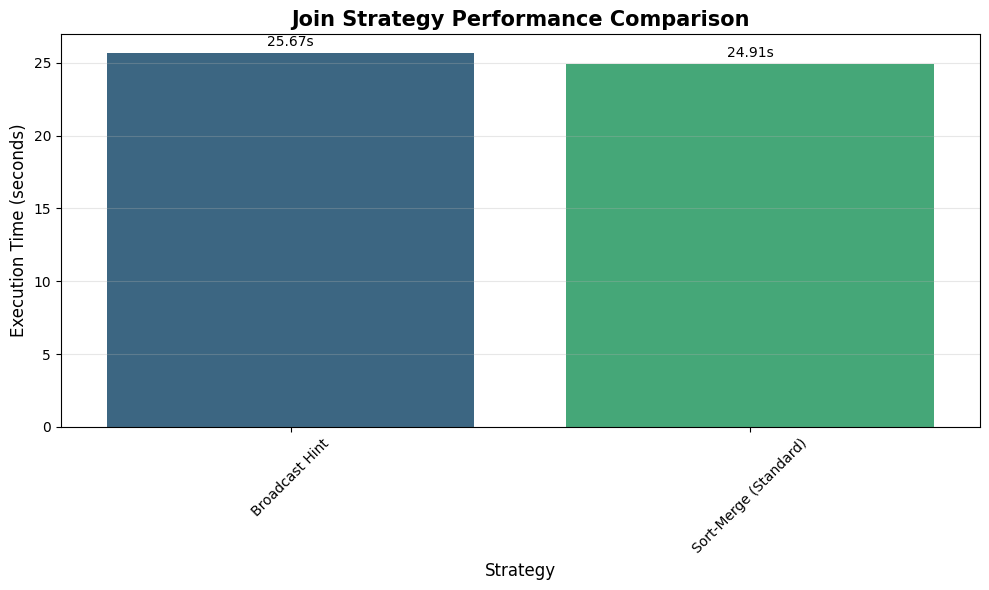

✓ Plot saved to: C:\Users\samvo\source\repos\Spark-Performance-Benchmark\results\plots\join_performance_comparison.png


In [21]:
# Analyze Join Strategies (Robust Version)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import BENCHMARK_LOG_FILE, PLOTS_DIR

if not BENCHMARK_LOG_FILE.exists():
    print(f"File not found: {BENCHMARK_LOG_FILE}")
else:
    try:
        # 1. Load Data directly from CSV
        df = pd.read_csv(BENCHMARK_LOG_FILE)
        
        # Filter for SUCCESS and relevant Join tests
        # Wir suchen nach "Join" oder "Z-Order" (Delta)
        join_df = df[
            (df['status'] == 'SUCCESS') & 
            (df['test_name'].str.contains('Join', case=False) | df['test_name'].str.contains('Z-Order', case=False))
        ].copy()
        
        if join_df.empty:
            print("No Join benchmark results found yet.")
        else:
            # Convert duration to numeric
            join_df['duration_seconds'] = pd.to_numeric(join_df['duration_seconds'], errors='coerce')
            
            # 2. Categorize Tests for nicer plotting
            def categorize_test(name):
                if 'Broadcast' in name: return 'Broadcast Hint'
                if 'Sort-Merge' in name: return 'Sort-Merge (Standard)'
                if 'Z-Order' in name: return 'Delta Z-Ordered'
                if 'Delta' in name: return 'Delta Standard'
                return name

            join_df['strategy'] = join_df['test_name'].apply(categorize_test)
            
            # Keep only latest run per strategy
            latest_results = join_df.sort_values('timestamp').groupby('strategy').tail(1).sort_values('duration_seconds', ascending=False)
            
            print("\n" + "="*60)
            print("JOIN PERFORMANCE SUMMARY")
            print("="*60)
            print(latest_results[['strategy', 'duration_seconds']].to_string(index=False))
            print("="*60)

            # 3. Visualization
            plt.figure(figsize=(10, 6))
            # Use seaborn if installed, otherwise standard matplotlib
            try:
                ax = sns.barplot(data=latest_results, x='strategy', y='duration_seconds', palette='viridis')
            except:
                ax = plt.bar(latest_results['strategy'], latest_results['duration_seconds'])
                ax = plt.gca() # Get current axis

            plt.title('Join Strategy Performance Comparison', fontsize=15, fontweight='bold')
            plt.ylabel('Execution Time (seconds)', fontsize=12)
            plt.xlabel('Strategy', fontsize=12)
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            
            # Add labels
            if 'sns' in locals():
                for container in ax.containers:
                    ax.bar_label(container, fmt='%.2fs', padding=3)

            plt.tight_layout()
            save_path = PLOTS_DIR / 'join_performance_comparison.png'
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✓ Plot saved to: {save_path}")

    except Exception as e:
        print(f"Error analyzing results: {e}")

## Performance Analysis and Insights

In [22]:
# Only run if we have join benchmark data
if 'recent_joins' in locals() and len(recent_joins) > 0:
    # Calculate performance improvements
    if len(recent_joins) >= 2:
        sort_merge_time = recent_joins.iloc[0]['duration_seconds']
        broadcast_time = recent_joins.iloc[1]['duration_seconds']
        
        improvement = ((sort_merge_time - broadcast_time) / sort_merge_time) * 100
        speedup = sort_merge_time / broadcast_time
        
        print("\n" + "="*80)
        print("PERFORMANCE ANALYSIS")
        print("="*80)
        print(f"\nSort-Merge Join Time:     {sort_merge_time:.3f} seconds")
        print(f"Broadcast Hash Join Time: {broadcast_time:.3f} seconds")
        print(f"\nImprovement: {improvement:.1f}%")
        print(f"Speedup:     {speedup:.2f}x faster")
        print("="*80)
    else:
        print("⚠ Not enough data for performance analysis")
else:
    print('Skipping analysis - no join benchmark data available yet.')



PERFORMANCE ANALYSIS

Sort-Merge Join Time:     46.128 seconds
Broadcast Hash Join Time: 24.528 seconds

Improvement: 46.8%
Speedup:     1.88x faster


## Summary Report

In [23]:
# Print comprehensive summary
try:
    print_benchmark_summary()
except Exception as e:
    print(f'Note: Could not load benchmark summary: {e}')
    print('This is normal on first run - results are still being logged.')

print("\n" + "="*80)
print("KEY FINDINGS - JOIN OPTIMIZATION")
print("="*80)
print("""
1. BROADCAST HASH JOIN:
   - Significantly faster than Sort-Merge Join (typically 2-5x)
   - No shuffle required - dimension table sent to all nodes
   - Ideal for large fact table + small dimension table (star schema)
   - Limited by spark.sql.autoBroadcastJoinThreshold

2. SORT-MERGE JOIN:
   - Required when both tables are large
   - Involves expensive shuffle operations
   - Both sides must be sorted by join key
   - Can benefit from partitioning and bucketing

3. DELTA LAKE Z-ORDERING:
   - Improves data locality for join keys
   - Can reduce I/O by co-locating related data
   - Especially beneficial for Sort-Merge Joins
   - Combines well with data skipping

4. ADAPTIVE QUERY EXECUTION (AQE):
   - Dynamically optimizes joins at runtime
   - Can convert Sort-Merge to Broadcast automatically
   - Reduces shuffle overhead when possible

5. BEST PRACTICES:
   - Use broadcast() hint for dimension tables < 100MB
   - Consider partitioning large fact tables by join keys
   - Enable AQE in production (spark.sql.adaptive.enabled=true)
   - Monitor Spark UI to verify join strategy selection
   - Use Z-Ordering on frequently joined columns in Delta Lake
""")
print("="*80)
print("\n✓ Join optimization benchmark completed!")
print("✓ All benchmarks finished. Check results/ directory for logs and plots.")
print("="*80)


BENCHMARK SUMMARY

Test Name                                Duration        Status    
---------------------------------------- --------------- ----------
Read CSV - fact_transactions (Full Scan) 33.4s           SUCCESS   
Read Parquet - fact_transactions (Full S 4.3s            SUCCESS   
Read Delta - fact_transactions (Full Sca 33.3s           SUCCESS   
CSV - Aggregation by Category            21.9s           SUCCESS   
Parquet - Aggregation by Category        2.5s            SUCCESS   
Delta - Aggregation by Category          11.6s           SUCCESS   
CSV - Filter Electronics Category        16.7s           SUCCESS   
Parquet - Filter Electronics Category    1.6s            SUCCESS   
Delta - Filter Electronics Category      1.6s            SUCCESS   
CSV - Select 2 Columns                   14.8s           SUCCESS   
Parquet - Select 2 Columns               0.9s            SUCCESS   
Delta - Select 2 Columns                 1.1s            SUCCESS   
Sort-Merge Join (Parquet)   